# Logistic Regression for Flight-Class Prediction

Before we dive in, let’s briefly recap **how Logistic Regression works** and why it’s appropriate for a multiclass ticket-class problem.

---

## Logistic Regression “Behind the Mask”

A logistic regression model predicts class probabilities by passing a weighted sum of inputs through a **sigmoid** (logistic) function:

\[
\sigma(z)\;=\;\frac{1}{1 + e^{-z}}
\]

where \(z = \theta^T x\).  For a multiclass (“softmax”) version, we compute one linear score per class and normalize via:

\[
P(y=k\mid x) = \frac{\exp(\theta_k^T x)}{\sum_j \exp(\theta_j^T x)}.
\]

Rather than minimizing squared errors (OLS), logistic uses **Maximum Likelihood Estimation (MLE)** to find the best \(\theta\).

---

## Task

In this notebook we will:

1. Load our **cleaned airfare** dataset  
2. Preprocess numeric and categorical features  
3. Resample rare classes with **SMOTE**  
4. Train a **multinomial** `LogisticRegression`  
5. Evaluate via **classification report** and **confusion matrix**

---




In [2]:
## 1 Setup

# standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn + imblearn pipeline & utilities
from sklearn.model_selection     import train_test_split
from sklearn.compose             import ColumnTransformer
from sklearn.preprocessing       import OneHotEncoder, StandardScaler
from imblearn.pipeline           import Pipeline as ImbPipeline
from imblearn.over_sampling      import SMOTE
from sklearn.linear_model        import LogisticRegression
from sklearn.metrics             import classification_report, confusion_matrix

sns.set_style("whitegrid")
%matplotlib inline

In [3]:
## 2 Load & Inspect Data

df = pd.read_csv(
    r"C:\Users\jbats\Projects\cmor438\supervised-learning\Logistic Regression\Cleaned_dataset.csv"
)
df.head()

df["Class"].value_counts()



Class
Economy            252033
Business           126834
Premium Economy     73077
First                 144
Name: count, dtype: int64

In [5]:
## 3 Define Features & Target

X = df.drop(columns=["Flight_code", "Class"])
y = df["Class"]

numeric_cols = ["Duration_in_hours", "Days_left", "Fare"]
categorical_cols = [
    "Journey_day", "Airline", "Source",
    "Departure", "Total_stops", "Arrival", "Destination"
]

In [6]:
## 4 Preprocessing, SMOTE, Model Pipeline

preprocessor = ColumnTransformer([
    ("num", StandardScaler(), numeric_cols),
    ("cat", OneHotEncoder(drop="first", sparse_output=False), categorical_cols)
])

clf = ImbPipeline([
    ("pre",   preprocessor),
    ("smote", SMOTE(random_state=42)),
    ("lr",    LogisticRegression(
        multi_class="multinomial",
        solver="saga",
        class_weight="balanced",
        max_iter=1000,
        verbose=0
    ))
])


In [7]:
## 5 Train/Test Split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


In [8]:
## 6 Fit and Predict

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)


c:\Users\jbats\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


                 precision    recall  f1-score   support

       Business       0.99      0.98      0.99     25367
        Economy       0.98      0.78      0.87     50407
          First       0.91      1.00      0.95        29
Premium Economy       0.55      0.93      0.69     14615

       accuracy                           0.86     90418
      macro avg       0.86      0.92      0.87     90418
   weighted avg       0.91      0.86      0.87     90418



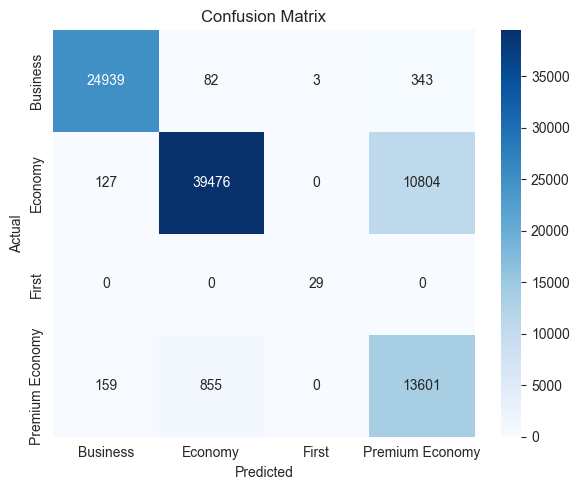

In [9]:
## 7 Eval and Confusion Matrix
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=clf.classes_,
            yticklabels=clf.classes_,
            cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


In [11]:
# 1) Grab the fitted logistic step
lr = clf.named_steps["lr"]

# 2) Build the full feature‐name list in the same order as your ColumnTransformer
num_feats = numeric_cols
cat_feats = clf.named_steps["pre"] \
              .named_transformers_["cat"] \
              .get_feature_names_out(categorical_cols) \
              .tolist()
all_feats = num_feats + cat_feats

# 3) Coefficients for each class (shape = [n_classes, n_features])
coefs = lr.coef_

# 4) For a *binary* model you'd do:
#    coef_vals = coefs[0]
#    df_imp = pd.DataFrame({
#      "feature": all_feats,
#      "coef":    coef_vals
#    })
#    df_imp["abs_coef"] = df_imp["coef"].abs()
#    print(df_imp.sort_values("abs_coef", ascending=False).head(10))

# 5) In your *multiclass* case, you can inspect one class at a time:
for cls, coef_vals in zip(lr.classes_, coefs):
    df_imp = pd.DataFrame({
      "feature": all_feats,
      "coef":    coef_vals
    })
    df_imp["abs_coef"] = df_imp["coef"].abs()
    print(f"\nTop 3 important for class = {cls!r}:")
    print(df_imp.sort_values("abs_coef", ascending=False)
                 .head(3)
                 .loc[:, ["feature","coef"]])


Top 3 important for class = 'Business':
             feature      coef
2               Fare  4.113116
13    Airline_Indigo -3.345749
12  Airline_GO FIRST -3.330236

Top 3 important for class = 'Economy':
                 feature       coef
2                   Fare -11.469537
27  Total_stops_non-stop  -8.756067
13        Airline_Indigo   3.408395

Top 3 important for class = 'First':
                 feature       coef
27  Total_stops_non-stop  14.520055
2                   Fare  12.178644
16       Airline_Vistara -11.647049

Top 3 important for class = 'Premium Economy':
                 feature       coef
16       Airline_Vistara  10.406791
27  Total_stops_non-stop  -6.176547
2                   Fare  -4.822223


## 8 Next Steps

1. **Feature engineering around “Fare” and “Stops”**  
   - One trend I am seeing is that the two biggest features that cause flight price consistantly except for Premium economy are Fare and Total_stops_non-stop. I will create derived features such as:  
     - **Fare per stop**: `Fare / (Total_stops + 1)`  
     - **Fare × Miles flown** to capture long-haul premium pricing  
   - Then I’ll evaluate whether these help better separate Economy, Premium Economy, and First.

2. **Airline-specific modeling**  
   - Since `Airline_Indigo` and `Airline_Vistara` were highly predictive, I will:  
     - Train **per-airline submodels** for the top carriers  
     - Add **interaction terms** between `Airline` and `Fare` or `Stops` to capture route-specific pricing effects
